In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("=== CrediTrust Financial - Complaint Analysis ===")
print("Task 1: Exploratory Data Analysis and Data Preprocessing\n")

=== CrediTrust Financial - Complaint Analysis ===
Task 1: Exploratory Data Analysis and Data Preprocessing



In [3]:
# Step 1: Load the data
print("1. Loading the complaint dataset...")
df = pd.read_csv(r'C:\Users\Antifragile\Desktop\credit-trust-complaint-bot\data\complaints.csv')
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

1. Loading the complaint dataset...
Dataset loaded: 9,609,797 rows, 18 columns


In [5]:
# Step 2: Basic data overview
print("\n2. Basic Data Overview:")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


2. Basic Data Overview:
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']
Data types:
Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Cons

In [6]:
# Step 3: Check for missing values
print("\n3. Missing Values Analysis:")
missing_info = df.isnull().sum()
missing_pct = (missing_info / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_info,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])


3. Missing Values Analysis:
                              Missing Count  Missing %
Tags                                8981029  93.457011
Consumer disputed?                  8841498  92.005044
Consumer complaint narrative        6629041  68.982113
Company public response             4770207  49.638999
Consumer consent provided?          1649561  17.165409
Sub-issue                            839522   8.736105
Sub-product                          235295   2.448491
State                                 54516   0.567296
ZIP code                              30228   0.314554
Company response to consumer             20   0.000208
Issue                                     6   0.000062


In [7]:
# Step 4: Product distribution analysis
print("\n4. Product Distribution Analysis:")
product_counts = df['Product'].value_counts()
print(f"Total unique products: {len(product_counts)}")
print(f"Top 10 products:")
print(product_counts.head(10))


4. Product Distribution Analysis:
Total unique products: 21
Top 10 products:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Name: count, dtype: int64


In [8]:
# Step 5: Focus on our target products
target_products = [
    'Credit card',
    'Personal loan', 
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfers'
]

print(f"\n5. Target Products Analysis:")
print(f"Looking for: {target_products}")
# Check which target products exist in the data
available_products = []
for product in target_products:
    if product in df['Product'].values:
        count = (df['Product'] == product).sum()
        available_products.append(product)
        print(f"✓ {product}: {count:,} complaints")
    else:
        print(f"✗ {product}: Not found in data")


5. Target Products Analysis:
Looking for: ['Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', 'Money transfers']
✓ Credit card: 226,686 complaints
✗ Personal loan: Not found in data
✗ Buy Now, Pay Later (BNPL): Not found in data
✗ Savings account: Not found in data
✓ Money transfers: 5,354 complaints


In [9]:
print(df['Product'].value_counts().head(20))


Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

In [10]:
# Check if 'buy now' or 'BNPL' appears in any complaint text
df[df['Consumer complaint narrative'].str.contains("buy now|bnpl", case=False, na=False)].shape


(190, 18)

In [28]:
# Step 5: First, let's see what products actually exist in the data
print(f"\n5. Exploring Available Products:")
print("All unique products in the dataset:")
all_products = df['Product'].value_counts()
print(all_products)

print(f"\nAll unique sub-products (first 20):")
all_subproducts = df['Sub-product'].value_counts()
print(all_subproducts.head(20))

# Now let's map our target products to what's actually in the data
target_mapping = {
    'Credit card': ['Credit card', 'Credit card or prepaid card'],
    'Personal loan': ['Personal loan', 'Payday loan', 'Installment loan'],
    'Buy Now, Pay Later (BNPL)': ['Buy Now, Pay Later (BNPL)'],  
    'Savings account': ['Savings account', 'Checking or savings account'],
    'Money transfers': ['Money transfers', 'Money transfer, virtual currency, or money service']
}

print(f"\n6. Target Products Analysis:")
print(f"Looking for our target products...")

# Check which target products exist in the data
available_products = []
final_product_mapping = {}

for target_product, possible_matches in target_mapping.items():
    found_matches = []
    total_count = 0
    
    for possible_match in possible_matches:
        # Check exact match
        if possible_match in df['Product'].values:
            count = (df['Product'] == possible_match).sum()
            if count > 0:
                found_matches.append(possible_match)
                total_count += count
        
        # Check case-insensitive match
        case_insensitive_match = df['Product'].str.lower().eq(possible_match.lower())
        if case_insensitive_match.any():
            actual_product = df[case_insensitive_match]['Product'].iloc[0]
            if actual_product not in found_matches:
                count = case_insensitive_match.sum()
                found_matches.append(actual_product)
                total_count += count
    
    if found_matches:
        available_products.extend(found_matches)
        final_product_mapping[target_product] = found_matches
        print(f"✓ {target_product}: {total_count:,} complaints")
        print(f"  Found in: {found_matches}")
    else:
        print(f"✗ {target_product}: Not found in main Product column")

# Special check for BNPL in narratives since you found 190 mentions
print(f"\n7. Special BNPL Analysis:")
bnpl_patterns = ['bnpl', 'buy now pay later', 'buy now, pay later', 'klarna', 'afterpay', 'affirm']
bnpl_in_narratives = df['Consumer complaint narrative'].fillna('').str.lower().str.contains('|'.join(bnpl_patterns))
bnpl_count = bnpl_in_narratives.sum()
print(f"Complaints mentioning BNPL-related terms in narratives: {bnpl_count:,}")

# Check sub-products for our targets
print(f"\n8. Checking Sub-products for our targets:")
subproduct_targets = [
    'personal loan', 'installment loan', 'payday loan',
    'checking account', 'savings account', 
    'domestic (us) money transfer', 'international money transfer'
]

def check_subproducts_chunked(df, targets, chunk_size=100000):
    results = {}
    subproduct_series = df['Sub-product'].fillna('').str.lower()

    for target in targets:
        target_lower = target.lower()
        total_count = 0
        
        for chunk_start in range(0, len(df), chunk_size):
            chunk_end = min(chunk_start + chunk_size, len(df))
            chunk = subproduct_series.iloc[chunk_start:chunk_end]
            
            matches = chunk.str.contains(target_lower)
            total_count += matches.sum()
        
        results[target] = total_count

    return results


# Get all unique actual products to work with
all_available_products = list(set(available_products))



5. Exploring Available Products:
All unique products in the dataset:
Product
credit reporting or other personal consumer reports                             4834855
credit reporting, credit repair services, or other personal consumer reports    2163857
debt collection                                                                  799197
mortgage                                                                         422254
checking or savings account                                                      291178
credit card                                                                      226686
credit card or prepaid card                                                      206369
money transfer, virtual currency, or money service                               145066
credit reporting                                                                 140429
student loan                                                                     109717
bank account or service                   

In [11]:
# Step 6: Analyze complaint narratives
print(f"\n6. Complaint Narrative Analysis:")
print(f"Total complaints: {len(df):,}")
print(f"Complaints with narratives: {df['Consumer complaint narrative'].notna().sum():,}")
print(f"Complaints without narratives: {df['Consumer complaint narrative'].isna().sum():,}")
print(f"Percentage with narratives: {(df['Consumer complaint narrative'].notna().sum() / len(df)) * 100:.1f}%")


6. Complaint Narrative Analysis:
Total complaints: 9,609,797
Complaints with narratives: 2,980,756
Complaints without narratives: 6,629,041
Percentage with narratives: 31.0%


In [13]:
# step7 Analyze narrative lengths
narratives_with_text = df['Consumer complaint narrative'].dropna()
if len(narratives_with_text) > 0:
    word_counts = narratives_with_text.apply(lambda x: len(str(x).split()))
    
    print(f"\n7. Narrative Length Statistics:")
    print(f"Mean word count: {word_counts.mean():.1f}")
    print(f"Median word count: {word_counts.median():.1f}")
    print(f"Min word count: {word_counts.min()}")
    print(f"Max word count: {word_counts.max()}")
    print(f"Standard deviation: {word_counts.std():.1f}")


7. Narrative Length Statistics:
Mean word count: 175.6
Median word count: 114.0
Min word count: 1
Max word count: 6469
Standard deviation: 225.9


In [14]:
#step8 creating product filter
import time

print("\n8. Creating Product Filter:")

# Start time
start_time = time.time()


# Optimize data types
df['Product'] = df['Product'].astype('category')
df['Sub-product'] = df['Sub-product'].astype('category')

# Preprocess narrative once
narrative_lower = df['Consumer complaint narrative'].fillna('').str.lower()

# Define conditions with exact matches
credit_card_condition = (
    df['Product'].str.contains(r'^Credit card$|^Credit card or prepaid card$', case=False, na=False, regex=True) |
    df['Sub-product'].str.contains(r'^General-purpose credit card$|^Store credit card$', case=False, na=False, regex=True)
)
personal_loan_condition = (
    df['Product'].str.contains(r'^Payday loan$|^Personal loan$', case=False, na=False, regex=True) |
    df['Sub-product'].str.contains(r'^Personal loan$|^Payday loan$', case=False, na=False, regex=True)
)
bnpl_condition = narrative_lower.str.contains(
    r'bnpl|buy now pay later|buy now, pay later|klarna|afterpay|affirm|sezzle|quadpay', na=False
)
savings_condition = (
    df['Product'].str.contains(r'^Checking or savings account$', case=False, na=False, regex=True) |
    df['Sub-product'].str.contains(r'^Savings account$|^Checking account$', case=False, na=False, regex=True)
)
money_transfer_condition = (
    df['Product'].str.contains(r'^Money transfer$|^Money transfers$|^Money transfer, virtual currency, or money service$', case=False, na=False, regex=True) |
    df['Sub-product'].str.contains(r'^Domestic money transfer$|^International money transfer$|^Mobile or digital wallet$', case=False, na=False, regex=True)
)

# Combine conditions
combined_condition = (
    credit_card_condition |
    personal_loan_condition |
    bnpl_condition |
    savings_condition |
    money_transfer_condition
)

# Filter
filtered_df = df[combined_condition].copy()

# Vectorized category assignment with mutual exclusivity
conditions = [
    credit_card_condition[filtered_df.index],
    personal_loan_condition[filtered_df.index] & ~credit_card_condition[filtered_df.index],
    bnpl_condition[filtered_df.index] & ~(credit_card_condition[filtered_df.index] | personal_loan_condition[filtered_df.index]),
    savings_condition[filtered_df.index] & ~(credit_card_condition[filtered_df.index] | personal_loan_condition[filtered_df.index] | bnpl_condition[filtered_df.index]),
    money_transfer_condition[filtered_df.index] & ~(credit_card_condition[filtered_df.index] | personal_loan_condition[filtered_df.index] | bnpl_condition[filtered_df.index] | savings_condition[filtered_df.index])
]
choices = ['Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', 'Money transfers']
filtered_df['Product_Category'] = np.select(conditions, choices, default='Other')

# Print results
print(f"Results of filtering:")
print(f"Original dataset: {len(df):,} rows")
print(f"After filtering: {len(filtered_df):,} rows\n")
print(f"Breakdown by our target categories:")
category_counts = filtered_df['Product_Category'].value_counts()
for category, count in category_counts.items():
    print(f"  {category}: {count:,}")

# Inspect Personal loan for over-counting
print("\nPersonal loan breakdown:")
print(filtered_df[filtered_df['Product_Category'] == 'Personal loan'][['Product', 'Sub-product']].value_counts().head())

# Print runtime
print(f"Runtime: {(time.time() - start_time):.2f} seconds")


8. Creating Product Filter:
Results of filtering:
Original dataset: 9,609,797 rows
After filtering: 980,814 rows

Breakdown by our target categories:
  Credit card: 433,055
  Savings account: 355,149
  Money transfers: 150,212
  Personal loan: 22,700
  Buy Now, Pay Later (BNPL): 19,698

Personal loan breakdown:
Product                                                  Sub-product
Debt collection                                          Payday loan    7545
Payday loan, title loan, or personal loan                Payday loan    6973
Payday loan, title loan, personal loan, or advance loan  Payday loan    2641
Name: count, dtype: int64
Runtime: 396.90 seconds


In [15]:
# Step 9: Filter data for our target products
print(f"\n9. Filtering Data for Target Products:")
filtered_df = filtered_df[filtered_df['Product_Category'] != 'Other'].copy()


9. Filtering Data for Target Products:


In [16]:
# Step 10: Continue with narrative filtering and cleaning
print(f"After category filtering: {len(filtered_df):,} rows")
# Remove rows with empty narratives
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].notna()].copy()
print(f"After removing empty narratives: {len(filtered_df):,} rows")

After category filtering: 980,814 rows
After removing empty narratives: 468,059 rows


In [17]:
# Step 11: Text preprocessing function
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# One-time setup (only needed once)
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_narrative(text):
    """Clean complaint narrative text for RAG processing"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Remove boilerplate
    boilerplate_patterns = [
        r'^i am writing to file a complaint',
        r'^i am filing this complaint',
        r'^this is a complaint regarding',
        r'^i would like to file a complaint'
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text)
    
    # Remove unwanted characters (preserve basic punctuation)
    text = re.sub(r'[^\w\s\.\,\!\?\-\:]', '', text)
    
    # Tokenize, remove stopwords, lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Rejoin and cleanup whitespace
    cleaned = ' '.join(tokens)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    return cleaned
print(f"\n13. Cleaning Narrative Text:")
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].apply(clean_narrative)

# Filter: Remove very short narratives (<10 words)
word_counts = filtered_df['cleaned_narrative'].apply(lambda x: len(x.split()))
filtered_df = filtered_df[word_counts >= 10].copy()
print(f"After removing narratives with < 10 words: {len(filtered_df):,} rows")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antifragile\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antifragile\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



13. Cleaning Narrative Text:
After removing narratives with < 10 words: 459,138 rows


##  Step 12: Exploratory Data Visualization

These visualizations provide insights into the filtered complaints data across our five target product categories: Credit card, Personal loan, BNPL, Savings account, and Money transfers.
###  1. Number of Complaints by Product Category

This bar chart shows how complaints are distributed across the five target product categories after filtering and cleaning.



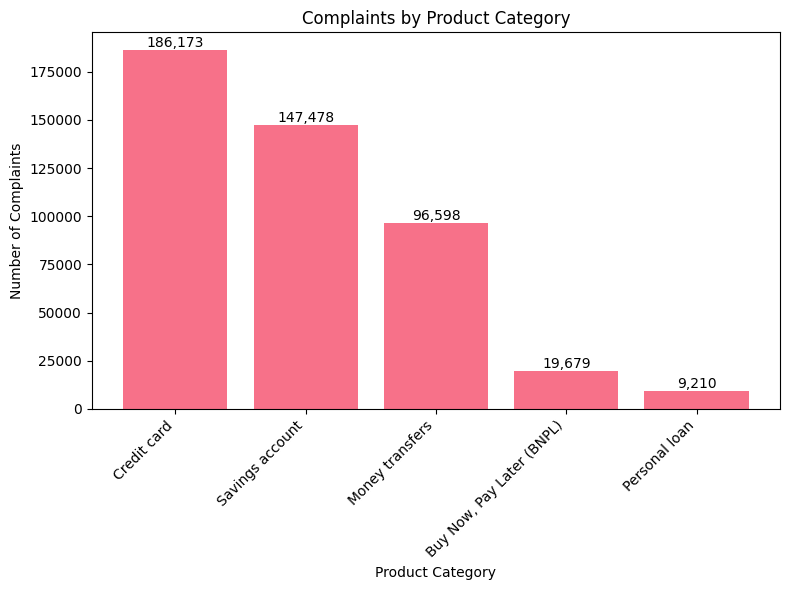

In [25]:
# Plot
plt.figure(figsize=(8, 6))
category_counts = filtered_df['Product_Category'].value_counts()
bars = plt.bar(range(len(category_counts)), category_counts.values)
plt.title('Complaints by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Complaints')
plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Narrative Length Distribution
This histogram shows the distribution of word counts in the `Consumer complaint narrative` column. It helps determine the typical length of narratives, which is critical for setting chunk sizes in Task 2’s text preprocessing and embedding steps.


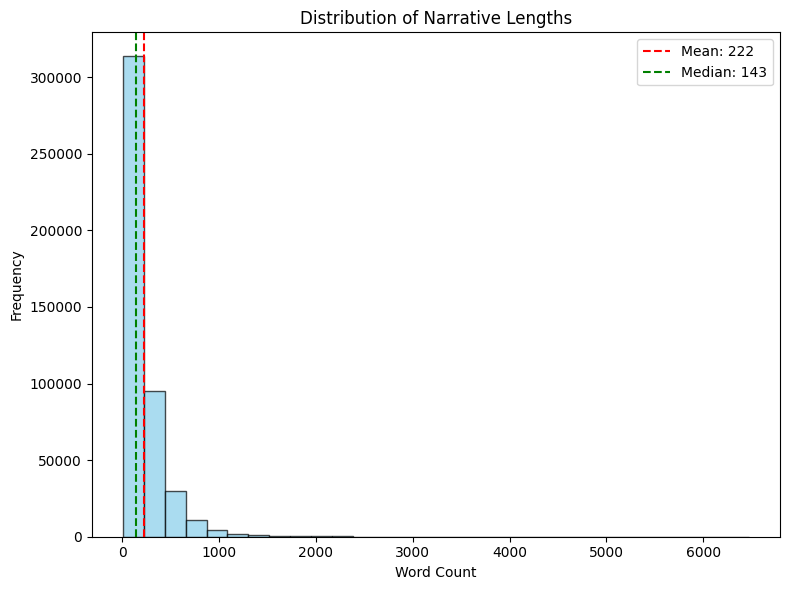

In [18]:
# Plot
plt.figure(figsize=(8, 6))
word_counts = filtered_df['Consumer complaint narrative'].fillna('').str.split().str.len()
plt.hist(word_counts, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Narrative Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.axvline(word_counts.mean(), color='red', linestyle='--', 
            label=f'Mean: {word_counts.mean():.0f}')
plt.axvline(word_counts.median(), color='green', linestyle='--', 
            label=f'Median: {word_counts.median():.0f}')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
 #Step 13: Final dataset summary
print(f"\n10. Final Dataset Summary:")
print(f"Total complaints: {len(filtered_df):,}")
print(f"Products included: {filtered_df['Product'].nunique()}")
print(f"Product breakdown:")
final_product_counts = filtered_df['Product'].value_counts()
for product, count in final_product_counts.items():
    print(f"  - {product}: {count:,}")

# Check final narrative lengths
final_word_counts = filtered_df['cleaned_narrative'].apply(lambda x: len(x.split()))
print(f"\nFinal narrative statistics:")
print(f"Mean word count: {final_word_counts.mean():.1f}")
print(f"Median word count: {final_word_counts.median():.1f}")
print(f"Min word count: {final_word_counts.min()}")
print(f"Max word count: {final_word_counts.max()}")


10. Final Dataset Summary:
Total complaints: 459,138
Products included: 20
Product breakdown:
  - Checking or savings account: 136,980
  - Credit card or prepaid card: 107,066
  - Money transfer, virtual currency, or money service: 95,330
  - Credit card: 79,107
  - Credit reporting or other personal consumer reports: 11,420
  - Bank account or service: 10,875
  - Payday loan, title loan, or personal loan: 4,425
  - Debt collection: 4,130
  - Credit reporting, credit repair services, or other personal consumer reports: 3,050
  - Payday loan, title loan, personal loan, or advance loan: 2,145
  - Payday loan: 1,699
  - Money transfers: 1,476
  - Mortgage: 945
  - Vehicle loan or lease: 195
  - Student loan: 128
  - Credit reporting: 80
  - Consumer Loan: 51
  - Debt or credit management: 19
  - Prepaid card: 16
  - Virtual currency: 1
  - Other financial service: 0

Final narrative statistics:
Mean word count: 116.5
Median word count: 74.0
Min word count: 10
Max word count: 3889


In [20]:
# Step 14: Save the cleaned dataset
print(f"\n11. Saving Cleaned Dataset:")
output_cols = [
    'Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
    'Consumer complaint narrative', 'cleaned_narrative', 'Company',
    'State', 'Complaint ID'
]

# Only keep columns that exist in the dataset
final_cols = [col for col in output_cols if col in filtered_df.columns]
final_df = filtered_df[final_cols].copy()

# Save to CSV
final_df.to_csv('../data/processed/filtered_complaints.csv', index=False)
print(f"Cleaned dataset saved to 'filtered_complaints.csv'")
print(f"Final dataset shape: {final_df.shape}")

print(f"\n=== Task 1 Complete ===")


11. Saving Cleaned Dataset:
Cleaned dataset saved to 'filtered_complaints.csv'
Final dataset shape: (459138, 10)

=== Task 1 Complete ===
